# Классификация токсичных комментариев

### Описание проекта ###
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Задача проекта:** обучить модель классифицировать комментарии на позитивные и негативные. Значение метрики качества *F1* должно быть  не меньше 0.75.


Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание проекта</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-данных" data-toc-modified-id="Импорт-библиотек-и-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек и данных</a></span></li><li><span><a href="#Первичное-изучение-данных" data-toc-modified-id="Первичное-изучение-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Первичное изучение данных</a></span></li><li><span><a href="#Подготовка-данных-к-обучению" data-toc-modified-id="Подготовка-данных-к-обучению-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных к обучению</a></span></li><li><span><a href="#Итоговые-выводы:" data-toc-modified-id="Итоговые-выводы:-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Итоговые выводы:</a></span></li></ul></li></ul></div>

## Подготовка

### Импорт библиотек и данных

In [ ]:
# Базовые библиоткеи
import pandas as pd
import numpy as np

# Модели и оценки
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score


# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Прогресс-бар
from tqdm import tqdm
from tqdm.notebook import tqdm

# Pytorch
import torch
from torch.utils.data import DataLoader, Dataset


!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Подключение Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/0 Education/toxic_comments.csv')

except:
    df = pd.read_csv('.../toxic_comments.csv')


### Первичное изучение данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
df.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [ ]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Удалим* столбец `Unnamed: 0`, так как он содержит дубликат индексов.

In [ ]:
df = df.drop('Unnamed: 0', axis=1)

Посмотрим на пример токсчичного и нетоксичного комментария

In [ ]:
non_toxic_example = df[df['toxic'] == 0]['text'].values[0]
toxic_example = df[df['toxic'] == 1]['text'].values[0]

print("Пример нетоксичного комментария:\n", non_toxic_example)
print("\nПример токсичного комментария:\n", toxic_example)


Пример нетоксичного комментария:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Пример токсичного комментария:
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


Таким образом, мы изучили данные и выяснили, что датасте состоит из 159 292 записей без пропусков. Каждая строка содержит текст комментария и категориальный признак токсичности.
Также мы посмотрели на пример нетоксичного и токсичного комментария, и были впечатлены экспрессией последнего :)


### Подготовка данных к обучению

Загрузим предобученную модель "unitary/toxic-bert" и токенизатор. Мы выбрали её, тк она она уже предобучена для классификации токсичных текстов.

In [ ]:
model_name = "unitary/toxic-bert"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Посмотрим как работает токенайзер

In [ ]:
tokenizer.encode('I want to tokenize this text', add_special_tokens=True)

[101, 1045, 2215, 2000, 19204, 4697, 2023, 3793, 102]

Токенизатор добавил специальные токены начала и конца последовательности и превратил каждое слово в числовое значение.

Применим метод padding (англ. «отступ»), чтобы после токенизации длины исходных текстов в корпусе были равными и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения.

In [ ]:
max_length = 280

tokens = tokenizer('I want to tokenize this text', padding="max_length", truncation=True, max_length=max_length, return_tensors="np")

# Получаем вектор с отступами и маску внимания
padded_vector = tokens["input_ids"][0]
attention_mask = tokens["attention_mask"][0]
print(padded_vector)
print(padded_vector.shape)
print()
print(attention_mask)
print(attention_mask.shape)

[  101  1045  2215  2000 19204  4697  2023  3793   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

Видим, что всё обработалось корректно:
- у вектора предложения есть специальные метки начала и конца текста.
- как и ожидалось, длинна векторов составила 280.
- маска "закрывает" все пустые значения.

Перейдем к следующему этапу и напишем функцию, которая обработает весь датасет.

In [ ]:
def tokenize_and_pad(text, max_length=280):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_length, return_tensors="np")
    return tokens["input_ids"][0], tokens["attention_mask"][0]

tqdm.pandas()
tokenized = df['text'].progress_apply(tokenize_and_pad)

padded, attention_mask = zip(*tokenized)
padded = np.array(padded)
attention_mask = np.array(attention_mask)

  0%|          | 0/159292 [00:00<?, ?it/s]

Определим класс `TextDataset`.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, masks):
        self.texts = texts
        self.masks = masks

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.masks[idx]

Напишем функцию для создания эмбендингов. Чтобы хватило оперативной памяти, сделаем размер батча 100.

In [ ]:
def create_embeddings(model, padded, attention_mask, batch_size=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataset = TextDataset(padded, attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    embeddings = []

    for batch, mask in tqdm(dataloader):
        batch = batch.to(device)
        mask = mask.to(device)

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=mask).last_hidden_state[:, 0, :].cpu().numpy()

        embeddings.append(batch_embeddings)

    return np.concatenate(embeddings)

Чтобы код работал быстрее, ограничимся 500 случаных элементов из выборки

In [ ]:
sample_df = df.sample(500, random_state=42)
sample_indices = sample_df.index
sample_padded = padded[sample_indices]
sample_attention_mask = attention_mask[sample_indices]

Создадим эмбендинги. На сервере `Google Collab` они будут создаваться около 10 минут, поэтому пока сходим за чаем :)



In [ ]:
sample_embeddings = create_embeddings(model, sample_padded, sample_attention_mask)



  0%|          | 0/5 [00:00<?, ?it/s]

Разделим выборки на обучающую и тестовую. Мы токенизировали текст до разделения на обучающую и тестовую выборки, но это не приведет к утечке данных, т.к. процесс токенизации не связан с метками классов.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sample_embeddings, sample_df['toxic'].values, test_size=0.5, random_state=42)

На этапе подготовки модели мы:
- Загрузили предобученный токенизатор "toxic-bert" и токенизировали тексты.
- Создали массивы, используя  padding и создали маски внимания (это необходимо для правильно работы BERT).
- Получили эмбендинги тестов.
- Разбили выборку на тренировочную и тестовую.

При этом, для более быстрого обучения мы ограницили тексты 280 токенами, а выборку 500 значениями.


# Обучение и тестирование модели

Обучим модель логистической регрессии на тренировочной выборке и протестируем качество предсказания на тестовой.

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1}")

F1-score: 0.9411764705882353


Построим и виуализируем матрицу ошибок.

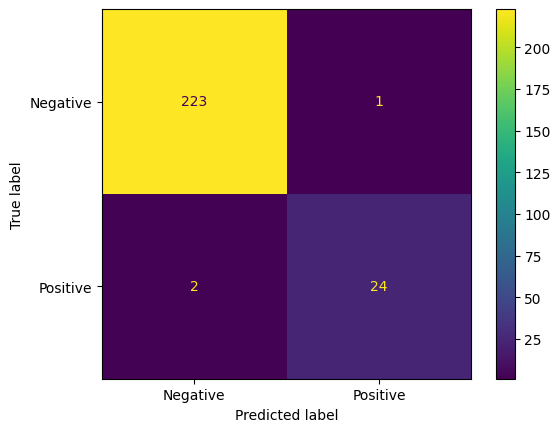

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Negative', 'Positive'])

cm_display.plot()
plt.show()


- Не смотря на ограничение длинны текста и выборки, модель показывает отличные показатели метрики F-1 — `0.94` .Из 250 текстов она неверно классифицировала только 3.


### Итоговые выводы:

- В проекте мы загрузили предобученную модель BERT (unitary/toxic-bert).
- Проанализировали и предобработали данные, преобразовали текст в токены и ограничивая их длину до 280, чтобы сохранить вычислительную эффективность и стандартизировать данные.
- Раздлелили датасет на тестовую и валидационную выборку, ограничив общее количество записей в 500 значений.
- Обучили модель логистической регресии и получили F-1 меру (среднее гармоническое точности и полноты) в размере `0.94`.
